let's see how long does it to run for one col

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import random_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('data.csv')
data.head()

,row_id,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


In [3]:
colF4 = [col for col in data.columns if col[0:3]=='F_4']
data = data[colF4]
data.head()

,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,1.914908,3.877128,NaN,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-2.638262,0.546676,0.865400,-0.857077,2.667105,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,-0.230342,-0.459019,1.128705,-0.748683,NaN,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


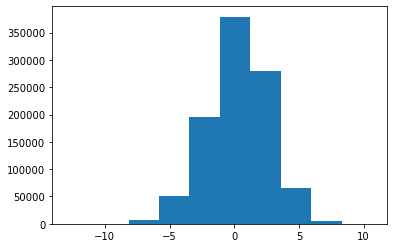

In [4]:
plt.hist(data.values[:,0]);

In [5]:
sc = MinMaxScaler(feature_range=(-1,1))
X_norm = sc.fit_transform(data.values)
means = np.nanmean(X_norm, axis=0)
means

array([ 0.12215822,  0.0081264 ,  0.52363379,  0.55646253,  0.06318847,
       -0.01269584, -0.01697574, -0.00782286,  0.57806483,  0.54337739,
        0.61090476, -0.06693178,  0.03713929, -0.02567595,  0.59464957])

(array([8.00000e+00, 3.90000e+02, 6.64500e+03, 5.00040e+04, 1.95823e+05,
        3.78967e+05, 2.79121e+05, 6.58650e+04, 4.92000e+03, 1.29000e+02]),
 array([-1.00000000e+00, -8.00000000e-01, -6.00000000e-01, -4.00000000e-01,
        -2.00000000e-01, -1.11022302e-16,  2.00000000e-01,  4.00000000e-01,
         6.00000000e-01,  8.00000000e-01,  1.00000000e+00]),
 <BarContainer object of 10 artists>)

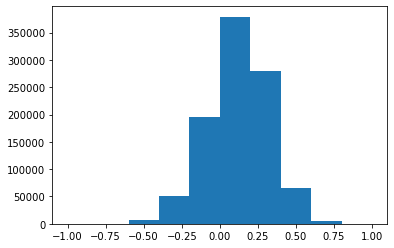

In [6]:
plt.hist(X_norm[:,0])

In [7]:
X = X_norm[np.sum(np.isnan(X_norm), axis=1)==0]
X.shape

(759268, 15)

In [8]:
class MyDataset(Dataset):
    ''' if nan=2, then nfill=1, 1 extra fill'''
    def __init__(self, X, icol, nfill):
        self.X = X
        self.icol = icol
        self.nfill = nfill
        self.idx = list(range(15))
        self.idx.remove(icol)
        self.idx = np.array(self.idx)
        print(self.idx)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx].copy()
        idx = np.random.choice(self.idx, self.nfill, replace=False)
#         print(idx)
        x[idx] = -1
        return torch.Tensor(np.hstack((x[:self.icol], x[self.icol+1:]))), torch.Tensor([x[self.icol]])

In [9]:
mydataset = MyDataset(X, 5, 1)

[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14]


In [10]:
X[0]

array([ 0.56580515,  0.12361231,  0.51591465,  0.57154503, -0.01712219,
        0.24869956,  0.05281905, -0.01354253,  0.50090001,  0.58696563,
        0.6628569 ,  0.12974683,  0.34117027,  0.05467003,  0.77682826])

In [11]:
for _ in range(5):
    print(mydataset[0])

(tensor([ 0.5658, -1.0000,  0.5159,  0.5715, -0.0171,  0.0528, -0.0135,  0.5009,
         0.5870,  0.6629,  0.1297,  0.3412,  0.0547,  0.7768]), tensor([0.2487]))
(tensor([ 0.5658,  0.1236,  0.5159,  0.5715, -1.0000,  0.0528, -0.0135,  0.5009,
         0.5870,  0.6629,  0.1297,  0.3412,  0.0547,  0.7768]), tensor([0.2487]))
(tensor([ 0.5658,  0.1236,  0.5159,  0.5715, -0.0171,  0.0528, -0.0135,  0.5009,
         0.5870,  0.6629,  0.1297,  0.3412,  0.0547, -1.0000]), tensor([0.2487]))
(tensor([ 0.5658,  0.1236,  0.5159,  0.5715, -0.0171,  0.0528, -0.0135,  0.5009,
         0.5870, -1.0000,  0.1297,  0.3412,  0.0547,  0.7768]), tensor([0.2487]))
(tensor([ 0.5658,  0.1236,  0.5159,  0.5715, -0.0171,  0.0528, -1.0000,  0.5009,
         0.5870,  0.6629,  0.1297,  0.3412,  0.0547,  0.7768]), tensor([0.2487]))


In [12]:
class Model(nn.Module):
    def __init__(self, input_dim=14, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*4)
        self.bn1 = nn.BatchNorm1d(hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.bn2 = nn.BatchNorm1d(hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.bn1(self.activation(self.fc1(x)))
        x = self.bn2(self.activation(self.fc2(x)))
        x = self.bn3(self.activation(self.fc3(x)))
        return nn.Tanh()(self.fc4(x))

In [13]:
# def val(model, dataloader):
#     criteria = nn.MSELoss()
#     model.eval()
#     with torch.no_grad():
#         loss_mean = 0
#         loss_median = 0
#         for X, y in dataloader:
#             predict = model(X)
#             loss = criteria(predict, y)
#             loss_mean += loss.item() * X.shape[0]
#             loss_median = (predict-y).abs().median().item() * X.shape[0]
#     return loss_mean / len(dataloader.dataset), loss_median / len(dataloader.dataset)

In [14]:
def val(model, dataloader):
    criteria = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        loss_mean = 0
        for X, y in dataloader:
            predict = model(X)
            loss = criteria(predict, y)
            loss_mean += loss.item() * X.shape[0]
    return loss_mean / len(dataloader.dataset)

In [15]:
def train(dataset, savename, epoches=1000, earlystop_patience=10):
    model = Model()
    
    n = len(dataset)
    n1 = int(0.9*n)
    n2 = n - n1
    train_dataset, val_dataset = random_split(dataset, [n1,n2])
    train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False, drop_last=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    criteria = nn.MSELoss()
    
#     print(f'starting loss={val(model, train_dataloader)}')
    
    val_loss_min = 100.
    best_epoch = 0
    
    for epoch in range(epoches):
        
        print(f'lr={optimizer.param_groups[0]["lr"]}')
        
        if epoch - best_epoch > earlystop_patience:
            print('early stop')
            break
        
        model.train()

        loss_mean = 0
        for X, y in train_dataloader:
            predict = model(X)
            loss = criteria(predict, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * X.shape[0]
        
        loss_mean /= len(train_dataloader.dataset)
        val_loss = val(model, val_dataloader)
        print(f"{datetime.now().strftime('%H:%M:%S')}-epoch {epoch}: training loss={loss_mean}, validation loss={val_loss}")
        scheduler.step(val_loss)
        
        if val_loss < val_loss_min:
            val_loss_min = val_loss
            best_epoch = epoch
            torch.save({'model':model.state_dict()}, savename)

In [16]:
X.shape

(759268, 15)

In [17]:
for icol in range(11, 13):
    print(f"======== doing {icol}  ========")
    mydataset = MyDataset(X, icol, 2)
    train(mydataset, f'model_2_{icol}.pickle')

======== doing 11  ========
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14]
lr=0.01
12:45:21-epoch 0: training loss=0.0137931010930644, validation loss=0.005908433230695633
lr=0.01
12:46:09-epoch 1: training loss=0.0042152321924581, validation loss=0.0037071867084508266
lr=0.01
12:47:07-epoch 2: training loss=0.0036945935424112825, validation loss=0.0033265083361413766
lr=0.01
12:47:59-epoch 3: training loss=0.0033901874284088425, validation loss=0.0031712814850288974
lr=0.01
12:48:49-epoch 4: training loss=0.003180911552460472, validation loss=0.0029418874285443335
lr=0.01
12:49:40-epoch 5: training loss=0.0029374013537723613, validation loss=0.0029224153457463055
lr=0.01
12:50:32-epoch 6: training loss=0.0027663212450280937, validation loss=0.002932719898483112
lr=0.01
12:51:23-epoch 7: training loss=0.002607998592795932, validation loss=0.0027484568281214428
lr=0.01
12:52:16-epoch 8: training loss=0.0024521966706321295, validation loss=0.002659956787017008
lr=0.01
12:53:33-epoch 9: trai

14:36:45-epoch 80: training loss=0.0009310935650328105, validation loss=0.0008217863222820961
lr=0.0001
14:37:49-epoch 81: training loss=0.0009223225713033498, validation loss=0.0008162705616361767
lr=0.0001
14:38:48-epoch 82: training loss=0.0009241269598534867, validation loss=0.0008199696045657763
lr=0.0001
14:39:48-epoch 83: training loss=0.0009214915458329639, validation loss=0.0008093079725721404
lr=0.0001
14:40:47-epoch 84: training loss=0.0009177399864485891, validation loss=0.00081206094308653
lr=0.0001
14:41:47-epoch 85: training loss=0.0009264467507590099, validation loss=0.0008150337954598772
lr=0.0001
14:42:46-epoch 86: training loss=0.0009142076492669636, validation loss=0.0008275009010726163
lr=0.0001
14:43:45-epoch 87: training loss=0.0009236551350989181, validation loss=0.000818769722978958
lr=0.0001
14:44:43-epoch 88: training loss=0.0009254839069669285, validation loss=0.0008256031210269672
lr=0.0001
14:45:41-epoch 89: training loss=0.0009171731348424065, validation 

16:07:05-epoch 57: training loss=0.006871161059870218, validation loss=0.006512398879635262
lr=0.001
16:08:09-epoch 58: training loss=0.006879101600414688, validation loss=0.00652042600623728
lr=0.001
16:09:14-epoch 59: training loss=0.006841680937736366, validation loss=0.006528252564733314
lr=0.001
16:10:15-epoch 60: training loss=0.006839189810200774, validation loss=0.006496807742708213
lr=0.001
16:11:14-epoch 61: training loss=0.006823315754588878, validation loss=0.00635127205999775
lr=0.001
16:12:20-epoch 62: training loss=0.006806852865191832, validation loss=0.006544104680957545
lr=0.001
16:13:27-epoch 63: training loss=0.006842753938398717, validation loss=0.006546823121710338
lr=0.001
16:14:34-epoch 64: training loss=0.006827981529643413, validation loss=0.006529256385189934
lr=0.001
16:15:41-epoch 65: training loss=0.006821099543850908, validation loss=0.0065605533094502755
lr=0.001
16:16:37-epoch 66: training loss=0.006799818140867066, validation loss=0.006426720066096608
